## E-Commerce Analytics

In [0]:
#1.Setup Your NotebooK
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, date_format, round, sum as spark_sum, avg as spark_avg, row_number, when
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()


In [0]:
#3.Create and Upload Data
customers_df = spark.read.csv("/FileStore/tables/customers.csv", header=True, inferSchema=True)
products_df  = spark.read.csv("/FileStore/tables/products.csv",  header=True, inferSchema=True)
orders_df    = spark.read.csv("/FileStore/tables/orders.csv",    header=True, inferSchema=True)

display(customers_df)
display(products_df)
display(orders_df)


customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


In [0]:
#Check Schemas and Basic Counts
customers_df.printSchema()
products_df.printSchema()
orders_df.printSchema()

print("Customers:", customers_df.count())
print("Products :", products_df.count())
print("Orders   :", orders_df.count())

root
 |-- customer_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- age: integer (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: integer (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- order_date: date (nullable = true)

Customers: 6
Products : 6
Orders   : 7


In [0]:
#4.Transformations
#1.Add total_price = quantity × price
joined_df = orders_df.join(products_df, "product_id")
orders_total_df = joined_df.withColumn("total_price", col("quantity") * col("price"))
display(orders_total_df)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


In [0]:
#2.Filter orders above 40,000
high_value_orders = orders_total_df.filter(col("total_price") > 40000)
display(high_value_orders)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


In [0]:
#3.Extract month from order_date
from pyspark.sql.functions import month

orders_total_df = orders_total_df.withColumn("order_month", month(col("order_date")))
display(orders_total_df)


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,order_month
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000,2
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000,2
105,1005,5,5,2024-03-01,Book,Stationery,700,3500,3
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000,3
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3


In [0]:
#4.Sort by total_price (descending)
sorted_orders = orders_total_df.orderBy(col("total_price").desc())
display(sorted_orders)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,order_month
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000,2
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000,2
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000,3
105,1005,5,5,2024-03-01,Book,Stationery,700,3500,3


In [0]:
#5.Aggregations
#1.Total revenue per city
revenue_city = orders_total_df.join(customers_df, "customer_id") \
    .groupBy("city").sum("total_price")
display(revenue_city)

city,sum(total_price)
Bangalore,64000
Delhi,55000
Mumbai,3500
Hyderabad,5000


In [0]:
#2.Average age per city
avg_age = customers_df.groupBy("city").avg("age")
display(avg_age)

city,avg(age)
Bangalore,28.0
Chennai,35.0
Delhi,30.5
Mumbai,30.0
Hyderabad,25.0


In [0]:
#3.Total revenue per category
revenue_category = orders_total_df.groupBy("category").sum("total_price")
display(revenue_category)

category,sum(total_price)
Furniture,5000
Stationery,3500
Electronics,169000
Fashion,5000


In [0]:
#4.Top 3 customers by spending
top_customers = orders_total_df.groupBy("customer_id").sum("total_price") \
    .orderBy(col("sum(total_price)").desc()).limit(3)
display(top_customers)

customer_id,sum(total_price)
1,64000
7,55000
2,50000


In [0]:
#6.Joins
#1.Inner, Left, Right Joins
inner_join = orders_df.join(customers_df, "customer_id", "inner")
display(inner_join)
left_join  = customers_df.join(orders_df, "customer_id", "left")
display(left_join)
right_join = orders_df.join(products_df, "product_id", "right")
display(right_join)

customer_id,order_id,product_id,quantity,order_date,name,city,age
1,1001,101,1,2024-01-10,Rahul Sharma,Bangalore,28
2,1002,102,2,2024-01-12,Priya Singh,Delhi,32
1,1003,103,3,2024-02-05,Rahul Sharma,Bangalore,28
3,1004,104,1,2024-02-08,Aman Kumar,Hyderabad,25
5,1005,105,5,2024-03-01,Arjun Mehta,Mumbai,30
6,1006,106,2,2024-03-15,Divya Nair,Delhi,29


customer_id,name,city,age,order_id,product_id,quantity,order_date
1,Rahul Sharma,Bangalore,28,1003,103,3,2024-02-05
4,Sneha Reddy,Chennai,35,null,null,null,null
6,Divya Nair,Delhi,29,1006,106,2,2024-03-15
3,Aman Kumar,Hyderabad,25,1004,104,1,2024-02-08
2,Priya Singh,Delhi,32,1002,102,2,2024-01-12
5,Arjun Mehta,Mumbai,30,1005,105,5,2024-03-01
1,Rahul Sharma,Bangalore,28,1001,101,1,2024-01-10


product_id,order_id,customer_id,quantity,order_date,product_name,category,price
102,1002,2,2,2024-01-12,Mobile,Electronics,25000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000
104,1004,3,1,2024-02-08,Chair,Furniture,5000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000
105,1005,5,5,2024-03-01,Book,Stationery,700
106,1006,6,2,2024-03-15,Shoes,Fashion,2500
101,1001,1,1,2024-01-10,Laptop,Electronics,55000


In [0]:
no_orders = left_join.filter(col("order_id").isNull())
display(no_orders)

no_sales = right_join.filter(col("order_id").isNull())
display(no_sales)


customer_id,name,city,age,order_id,product_id,quantity,order_date
4,Sneha Reddy,Chennai,35,null,null,null,null


product_id,order_id,customer_id,quantity,order_date,product_name,category,price


In [0]:
#7.PySpark SQL
#Register as temporary SQL tables:

customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders")

In [0]:
#Top 2 cities by total revenue
display(spark.sql("""
SELECT c.city,SUM(o.total_price) AS revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.city
ORDER BY revenue DESC
LIMIT 2
"""))

city,revenue
Bangalore,64000
Delhi,55000


In [0]:
#2.Most popular category by revenue
display(spark.sql("""
SELECT category, SUM(total_price) AS revenue
FROM orders
GROUP BY category
ORDER BY revenue DESC
LIMIT 1
"""))

category,revenue
Electronics,169000


In [0]:
#3.Customers who spent > 50,000
display(spark.sql("""
SELECT c.name, SUM(o.total_price) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.name
HAVING SUM(o.total_price) > 50000
"""))

name,total_spent
Rahul Sharma,64000


In [0]:
#4.Monthly sales trend
display(spark.sql("""
SELECT MONTH(order_date) AS month, SUM(total_price) AS total_sales
FROM orders
GROUP BY MONTH(order_date)
ORDER BY month
"""))

month,total_sales
1,105000
2,14000
3,63500


In [0]:
#8-File Operations
#Save results to DBFS
orders_total_df.write.mode("overwrite").csv("/FileStore/tables/orders_summary")

#Verify saved files
display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

#Read back
summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True, inferSchema=True)
display(summary_df)

path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759840321000
dbfs:/FileStore/tables/orders_summary/_committed_1790413267489967882,_committed_1790413267489967882,113,1759840321000
dbfs:/FileStore/tables/orders_summary/_started_1790413267489967882,_started_1790413267489967882,0,1759840321000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-1790413267489967882-66856597-2efb-47c8-a73e-7da0512888ff-264-1-c000.csv,part-00000-tid-1790413267489967882-66856597-2efb-47c8-a73e-7da0512888ff-264-1-c000.csv,383,1759840321000


101,1001,12,13,2024-01-10,Laptop,Electronics,550007,550008,19
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000,2
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000,2
105,1005,5,5,2024-03-01,Book,Stationery,700,3500,3
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000,3
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3


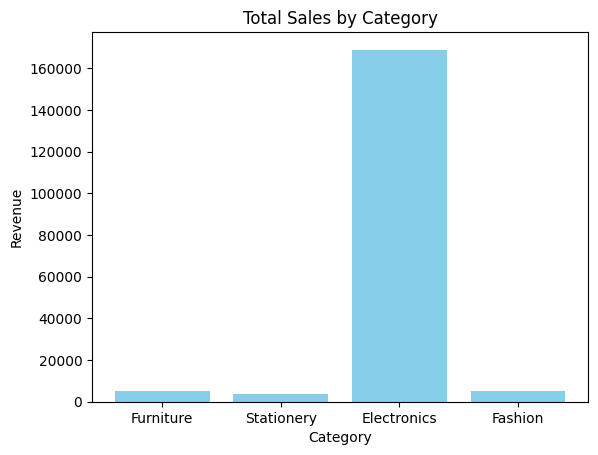

In [0]:
#9–Visualization

import matplotlib.pyplot as plt

region_df = orders_total_df.groupBy("category").sum("total_price").toPandas()

plt.bar(region_df["category"], region_df["sum(total_price)"], color="skyblue")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()
